## **Brain  mask segmentation with Deep Learning**







L'objectif de cet atelier est de tester un reseau unet "basique" pour la segmentation d'une IRM de cerveau.

principaux packages python utilisés:
Tensorflow et Keras pour le deeplearning
nibabel pour la manipulation de volume 3D au format nifti
numpy et matplotlib

Le training sera réalisé avec une base de données d'images pondérées T1w d'un seul volume 3D (splitté en 146 coupes 2D) et leur masque associé (masque binaire: 1 = cerveau , 0 = other)

Le testing sera réalisé sur deux bases de données différentes, cad la même base de données training et une autre base de données  d'un seul volume 3D (un sujet) composé de 69 coupes T1w et masques associés.

Le premier exercice consistera à entrainer le reseau unet à partir d'une seule image et evaluer les performances.
Le second exercice consistera à mettre en évidence l'apport du DA pour améliorer les performances et la robustesse du réseau.

In [5]:
import tensorflow as tf
#from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import *
import tensorflow
import matplotlib.pyplot as plt
import nibabel as nib
from keras import backend as K
from keras.layers import Dropout, Lambda
import os 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,BatchNormalization,concatenate,ReLU,LeakyReLU,Add,Activation,Input,MaxPool2D,MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D,UpSampling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.transform import resize
from scipy.spatial.distance import directed_hausdorff
import numpy as np

Installer package gdown (via pip) pour télécharger des archives de google drive

https://clay-atlas.com/us/blog/2021/07/01/python-en-gdown-package-download-file-google-drive/

In [6]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [7]:
!gdown https://drive.google.com/uc?id=17gb7VFUgoHzUWc3eH_gxdmNekLLZQEIO
!gdown https://drive.google.com/uc?id=16-bZCe4whMnMfBjXBZwhPS16Uxet_x07



Downloading...
From: https://drive.google.com/uc?id=17gb7VFUgoHzUWc3eH_gxdmNekLLZQEIO
To: c:\Users\Jalil\Desktop\Ecole\M2TSI\initiation_segm\training.zip

  0%|          | 0.00/3.00M [00:00<?, ?B/s]
100%|██████████| 3.00M/3.00M [00:00<00:00, 38.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=16-bZCe4whMnMfBjXBZwhPS16Uxet_x07
To: c:\Users\Jalil\Desktop\Ecole\M2TSI\initiation_segm\testing.zip

  0%|          | 0.00/2.40M [00:00<?, ?B/s]
100%|██████████| 2.40M/2.40M [00:00<00:00, 27.5MB/s]


In [8]:
!unzip training
!unzip testing


'unzip' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
'unzip' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Q1: Ecrire une fonction qui lit un couple d'image (T1,mask) au format "nii.gz" d'un dataset (training ou testing),
entrées: path, index

Utilisez nib.load
variable t1, mask pour la lecture
et get_fdata() pour récupérer la matrice image

la fonction zfill pour gérer l'index:
txt = "50"
x = txt.zfill(10)
print(x)

In [11]:
def read_image_nii(folder, index):
  t1= nib.load(os.path.join(folder, 'T1_' + str(index).zfill(4) + '.nii.gz'))
  mask = nib.load(os.path.join(folder, 'mask_' + str(index).zfill(4) + '.nii.gz'))
  t1_data=t1.get_fdata()
  mask_data=mask.get_fdata()
  return (t1_data,mask_data)

2D image size: 


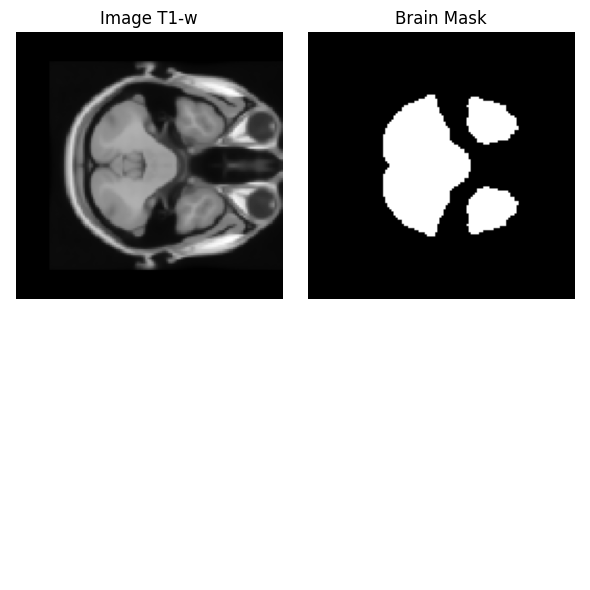

In [12]:
mon_index = 20

t1_data,mask_data=read_image_nii("../datasets/tp1_segm/training", mon_index)
print("2D image size: ")

plt.figure(figsize=(6,6))
plt.axis('Off')
plt.subplot(2,2,1)
plt.imshow(t1_data, cmap="gray", origin="lower")
plt.title('Image T1-w')
plt.axis('off')
plt.subplot(2,2,2)
plt.title("Brain Mask")
plt.imshow(mask_data, cmap="gray", origin="lower")
plt.axis('Off')
plt.tight_layout()
plt.show()

In [14]:
#recupérer le nombre d'images dans la base training

path_train, dirs_train, files_train = next(os.walk("../datasets/tp1_segm/training"))
path_test, dirs_test, files_test = next(os.walk("../datasets/tp1_segm/testing"))

nb_images_train = len(files_train)//2
nb_images_test = len(files_test)//2

print(f'nb_images_train : {nb_images_train}')
print(f'nb_images_test : {nb_images_test}')

nb_images_train : 146
nb_images_test : 69


Q2: Créer deux tableaux X_train,Y_train au format numpy de taille (mon_index,128,128,1) qui stockent respectivement les images T1w et masques binaires.

Créer deux tableaux X_test,Y_test au format numpy de taille (nb_images - 1,128,128,1) qui stockent respectivement les images T1w et masques binaires.


Attention:
could not broadcast input array from shape (128,128) into shape (128,128,1)
-> use image_data = np.expand_dims(image_data, axis=-1)


In [24]:
# Importing all images for training and test

X_train = np.empty((nb_images_train, 128, 128))
y_train = np.empty((nb_images_train, 128, 128))

X_test = np.empty((nb_images_test, 128, 128))
y_test = np.empty((nb_images_test, 128, 128))

for index in range(nb_images_train):
    X_train[index], y_train[index] = read_image_nii(path_train, index=index)

for index in range(nb_images_test):
    X_test[index], y_test[index] = read_image_nii(path_test, index=index)


In [27]:
print(X_train.shape)
print(X_test.shape)

(146, 128, 128, 1)
(69, 128, 128, 1)


In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [ ]:
# Importing images for training

mon_index = ...

index_train = 0
index_test = 0

X_train = np.zeros((1, 128, 128, 1))
Y_train = np.zeros((1, 128, 128, 1))

X_test = ...
Y_test = ...

for sujet_index in range (0,nb_images):
  t1_data,mask_data=read_image_nii("/content/training/", sujet_index)

  mask_data = np.expand_dims(mask_data, axis=-1)
  t1_data = np.expand_dims(t1_data, axis=-1)

  if (sujet_index==mon_index):
    ...
    ...
    index_train+=1

  else:
    ...
    ...
    index_test+=1

print("parsing dataset done !")

In [ ]:
print (index_train,index_test,nb_images)

1 145 146


In [28]:
# Description of U-Net

inputs = Input((128, 128, 1))
drop_out=0.0

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(drop_out) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(drop_out) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(drop_out) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(drop_out) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(drop_out) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(drop_out) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(drop_out) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(drop_out) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(drop_out) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [29]:
# Description of model to use

model = Model(inputs=[inputs], outputs=[outputs])
#test other loss function (loss=dice_coef_loss)
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
y_train.shape

(146, 128, 128)

In [31]:
# Unet training
valid=0.0 # data validation percentage rate
earlystopper = EarlyStopping(patience=50, verbose=1)
#checkpointer = ModelCheckpoint('my_model_unet_mask_segmentation.h5', verbose=1, save_best_only=True, mode='min')
results = model.fit(X_train, y_train, validation_split=valid, batch_size=1, epochs=10)

Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7558 - loss: 3.9367
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7504 - loss: 4.0229
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7487 - loss: 4.0510
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7469 - loss: 4.0802
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7472 - loss: 4.0750
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7464 - loss: 4.0876
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7493 - loss: 4.0405
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7572 - loss: 3.9140
Epoch 9/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7638 - loss: 3.8077
Epoch 10/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7372 - loss: 4.2357


In [ ]:
#save model
model.save('./my_first_model.h5')

In [34]:
print(results.model)

<Functional name=functional, built=True>


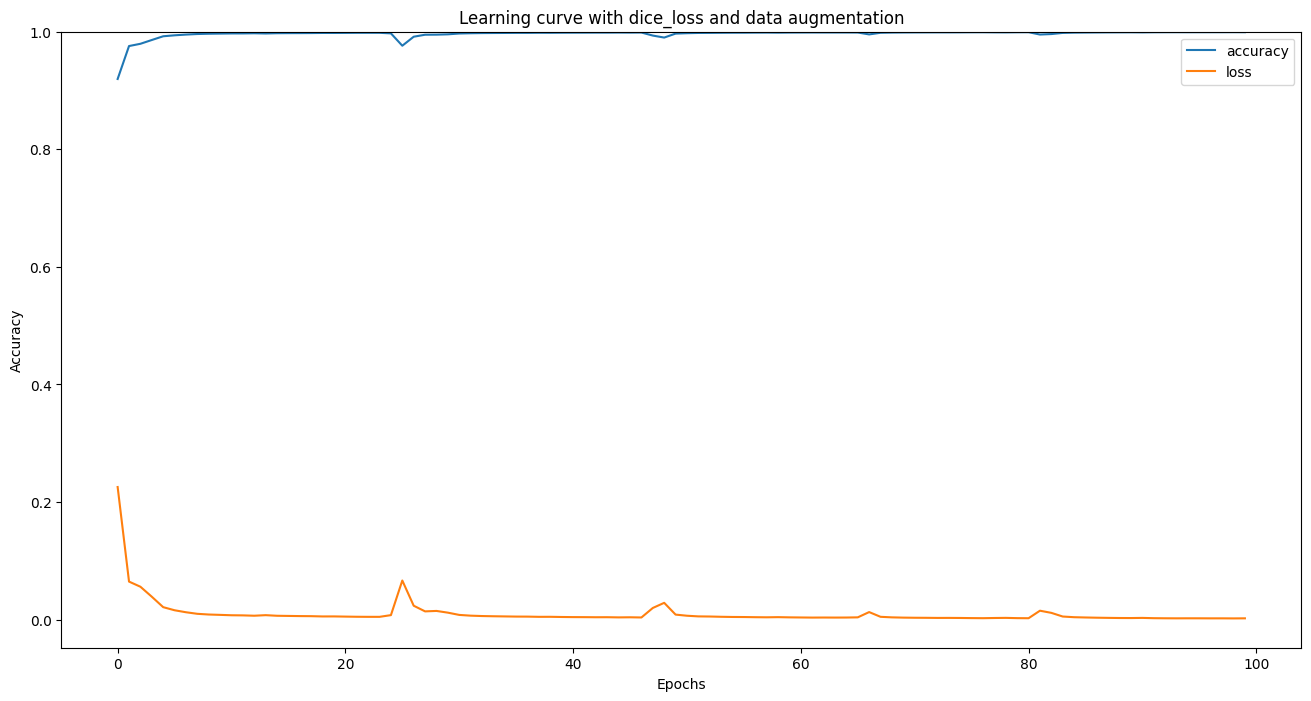

In [35]:
# Learning curve (Accuracy and loss on training dataset)
plt.figure(figsize=(16,8))
plt.title("Learning curve with dice_loss and data augmentation")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["loss"], label="loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(ymax=1)  # this line
plt.legend()

#add curve of validation loss (if option is activated)

In [36]:
#Implementation of Dice_loss for keras
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# Implementarion DICE SCORE COEFFICIENT for testing of images
def dice(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0

    dice = ...
    return dice

# Implementation HAUSDORFF DISTANCE for testing of images
def hausdorff_distance (pred, true):
  haus = max(directed_hausdorff(pred, true)[0], directed_hausdorff(true, pred)[0])
  return haus

In [ ]:
# Make a prediction with the best epoch
test_preds = model.predict(X_test)
preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)
all_dice_testing=[]
all_hausdorff_testing=[]

for sujet_index in range (0,len(X_test)-1):
#for sujet_index in range (0,nb_images_testing-1):
  img_anat = X_test[sujet_index, :, :, 0]
  img_true = Y_test[sujet_index, :, :, 0]
  img_pred = test_preds[sujet_index, :, :, 0]
  img_pred_th = preds_test_thresh[sujet_index, :, :, 0]

  # Calculation of segmentation quality metrics
  dice_score = dice(img_pred_th, img_true)

  # add dice score of all_dice_testing list
  all_dice_testing.append(dice_score)

  # compute hausdorff_distance between img_pred_th and img_true
  ...
  # add metric in the all_hausdorff_testing list
  ...

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [ ]:
# plot on a figure the results ...
#use 2 subplots (the first for dice and second for HD)

...

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('Off')

Slide_row_1=...

# == row 1 ==
plt.subplot(3,3,1)
test_image = X_test[Slide_row_1, :, :, 0]
plt.imshow(test_image, cmap='gray')
plt.title('Test Image 01', fontsize=14)
plt.axis('off')

# true mask
plt.subplot(3,3,2)
true_mask=Y_test[Slide_row_1, :, :, 0]
plt.imshow(true_mask, cmap='gray')
plt.title('True Mask', fontsize=14)

plt.subplot(3,3,3)
inf_mask=test_preds[Slide_row_1, :, :, 0]
plt.imshow(inf_mask, cmap='gray')
plt.title('predicted Mask', fontsize=14)

plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#testing on the extern dataset

#recupérer le nombre d'images dans la base testing
path, dirs, files = next(os.walk("/content/testing"))
nb_images_testing = int(len(files)/2)
print(nb_images_testing)

# Importing images for training

X_test_extern = np.zeros((nb_images_testing, 128, 128, 1))
Y_test_extern = np.zeros((nb_images_testing, 128, 128, 1))

...
...

69


In [ ]:
# Make a prediction with the best epoch
test_preds_extern = model.predict(X_test_extern)
preds_test_extern_thresh = (test_preds_extern >= 0.5).astype(np.uint8)
all_dice_testing=[]
all_hausdorff_testing=[]

...
...

In [ ]:
!pip install Keras-Preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.5 MB/s eta 0:00:00


In [ ]:
# Data Augmentation

from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
                        layers.RandomFlip(mode="horizontal_and_vertical", seed=1),
                        layers.RandomRotation(factor=0.20, fill_mode="constant", fill_value=0, seed=1),
                        layers.RandomZoom(height_factor=(0.3,-0.3), fill_mode='constant', fill_value=0, seed=1)])

X_train_augmented = X_train
Y_train_augmented = Y_train

for x in range(5):
  ds_concatenate = np.concatenate((X_train_augmented,Y_train_augmented), axis=3)
  ds_concatenate_augmented=data_augmentation(ds_concatenate)

  X_train_augmented=ds_concatenate_augmented[:,:,:,0:1]
  X_train_augmented=np.concatenate((X_train,X_train_augmented), axis=0)

  Y_train_augmented=ds_concatenate_augmented[:,:,:,1:2]
  Y_train_augmented=np.concatenate((Y_train,Y_train_augmented), axis=0)



In [ ]:
print(X_train_augmented.shape)

(6, 128, 128, 1)


In [ ]:
layers.RandomContrast

1


<ipython-input-78-3fe3a5cab594>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


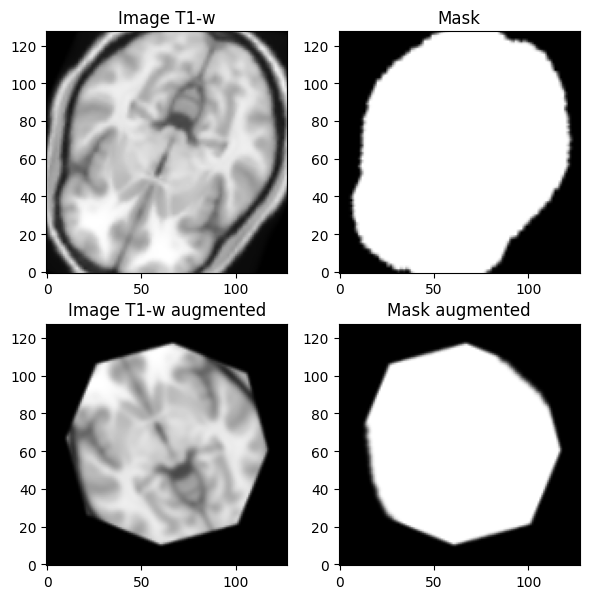

Total images for training without data augmentation =  1
Total images for training with data augmentation =  6


In [ ]:
Y_train_augmented.shape
print (len(X_train))

plt.figure(figsize=(6,6))
plt.axis('Off')
Slide_show=1
plt.subplot(2,2,1)
plt.imshow(X_train_augmented[Slide_show,:,:,0],cmap="gray", origin="lower")
plt.title('Image T1-w')
plt.subplot(2,2,2)
plt.title("Mask")
plt.imshow(Y_train_augmented[Slide_show,:,:,0],cmap="gray", origin="lower")
plt.tight_layout()
plt.subplot(2,2,3)
plt.imshow(X_train_augmented[Slide_show + 3*len(X_train),:,:,0],cmap="gray", origin="lower")
plt.title('Image T1-w augmented')
plt.subplot(2,2,4)
plt.title("Mask augmented")
plt.imshow(Y_train_augmented[Slide_show + 3*len(X_train) ,:,:,0],cmap="gray", origin="lower")
plt.tight_layout()
plt.show()

print("Total images for training without data augmentation = ",(X_train.shape)[0])
print("Total images for training with data augmentation = ", (X_train_augmented.shape)[0])

In [ ]:
# Unet training
valid=0.15 # data validation percentage rate
earlystopper = EarlyStopping(patience=50, verbose=1)
CKPT_path = "my_model.weights.h5"
checkpointer = ModelCheckpoint(".keras", verbose=1, save_best_only=True, mode='min')
results = model.fit(X_train_augmented, Y_train_augmented, validation_split=valid, batch_size=15, epochs=150, callbacks=[earlystopper, checkpointer])
# for work without data augmentation reemplace X_train_augmented, Y_train_augmented for X_train, Y_train